<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
How to match FIREX-AQ MASTER L1 and L2 Files with python ?
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>


In [1]:
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree
from matplotlib.pyplot import figure
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *
from scipy import constants

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import math
import random
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

warnings.filterwarnings('ignore')

In [2]:
root = '/Volumes/HD2/Datasets/Research'

In [3]:
MASTERFRP_Files = glob.glob('{}/MASTERFRP/*.nc'.format(root))

print( len(MASTERFRP_Files) )

275


In [4]:
MASTERFRP_File = '/Volumes/HD2/Datasets/Research/MASTERFRP/MASTERFRP_1981715_15_20190730_0219_0231_V01.nc'

In [5]:
filename = MASTERFRP_File.split('/')[-1]

year = filename.split('_')[3][0:4]
month = filename.split('_')[3][4:6]
day = filename.split('_')[3][6:8]

hour = filename.split('_')[4][0:2]
minute = filename.split('_')[4][2:4]

Flight_Number = filename.split('_')[1]
Flight_Track = filename.split('_')[2]

print(year,month,day)
print(hour,minute)
                                   
print(Flight_Number, Flight_Track)

2019 07 30
02 19
1981715 15


In [6]:
f = netCDF4.Dataset(MASTERFRP_File)

In [7]:
sds_shape = 0

df = pd.DataFrame()

for key,variable in f.variables.items():
    sds = f.variables[key]
    data = ma.getdata(sds)
    if sds_shape == 0:
        sds_shape = data.shape
    df[key] = data.ravel()
    
print(df)

        FRP  MASK   Longitude   Latitude
0       0.0     0 -121.214928  41.868652
1       0.0     0 -121.214813  41.868549
2       0.0     0 -121.214699  41.868443
3       0.0     0 -121.214584  41.868332
4       0.0     0 -121.214470  41.868225
...     ...   ...         ...        ...
435827  0.0     0 -121.271240  41.782211
435828  0.0     0 -121.271126  41.782104
435829  0.0     0 -121.271004  41.781994
435830  0.0     0 -121.270874  41.781868
435831  0.0     0 -121.270760  41.781761

[435832 rows x 4 columns]


In [8]:
print(df)

        FRP  MASK   Longitude   Latitude
0       0.0     0 -121.214928  41.868652
1       0.0     0 -121.214813  41.868549
2       0.0     0 -121.214699  41.868443
3       0.0     0 -121.214584  41.868332
4       0.0     0 -121.214470  41.868225
...     ...   ...         ...        ...
435827  0.0     0 -121.271240  41.782211
435828  0.0     0 -121.271126  41.782104
435829  0.0     0 -121.271004  41.781994
435830  0.0     0 -121.270874  41.781868
435831  0.0     0 -121.270760  41.781761

[435832 rows x 4 columns]


In [9]:
f.close()

In [10]:
path_to_L1 = '/Volumes/HD2/Datasets/Research/NASA/FIREXAQ/L1/'

In [11]:
MASTER_L1_Files = glob.glob('{}*.hdf'.format(path_to_L1))

len(MASTER_L1_Files)

354

In [12]:
filename.split('_')

['MASTERFRP', '1981715', '15', '20190730', '0219', '0231', 'V01.nc']

In [13]:
stamp = '_'.join( filename.split('_')[1:5] )
stamp

'1981715_15_20190730_0219'

In [14]:
[f for f in MASTER_L1_Files if stamp in f]

['/Volumes/HD2/Datasets/Research/NASA/FIREXAQ/L1/MASTERL1B_1981715_15_20190730_0219_0231_V01.hdf']

In [15]:
file_name = '/Volumes/HD2/Datasets/Research/NASA/FIREXAQ/L1/MASTERL1B_1981715_15_20190730_0219_0231_V01.hdf'

file = SD(file_name, SDC.READ)

file.info()

(38, 49)

In [16]:
df_wl = pd.DataFrame()

for variable in ['Left50%ResponseWavelength','Central100%ResponseWavelength','Right50%ResponseWavelength']:
    sds_obj = file.select(variable)
    data = sds_obj.get() # get sds data
    df_wl[variable] = data.ravel()
    
df_wl['Spectral_Width'] = df_wl['Right50%ResponseWavelength'] - df_wl['Left50%ResponseWavelength']

df_wl.index += 1 

df_wl 

,Left50%ResponseWavelength,Central100%ResponseWavelength,Right50%ResponseWavelength,Spectral_Width
1,0.440,0.462,0.481,0.041000
2,0.477,0.500,0.522,0.045000
3,0.521,0.546,0.564,0.043000
4,0.562,0.580,0.603,0.041000
5,0.633,0.654,0.692,0.059000
6,0.692,0.712,0.733,0.041000
7,0.732,0.752,0.772,0.040000
8,0.781,0.802,0.822,0.041000
9,0.847,0.868,0.888,0.041000
10,0.887,0.906,0.928,0.041000


In [17]:
df_L1 = pd.DataFrame()

for variable in ['PixelLongitude','PixelLatitude']:
    sds_obj = file.select(variable)
    data = sds_obj.get() # get sds data
    variable = variable.replace('Pixel', '')
    df_L1[variable] = data.ravel()
    
df_L1['A'] = -999
    
print(df_L1)

           Longitude   Latitude    A
0        -120.371639  42.494111 -999
1        -120.371405  42.493905 -999
2        -120.371191  42.493716 -999
3        -120.371054  42.493590 -999
4        -120.370844  42.493405 -999
...              ...        ...  ...
12422595 -121.414409  41.654469 -999
12422596 -121.414205  41.654282 -999
12422597 -121.414020  41.654113 -999
12422598 -121.413863  41.653969 -999
12422599 -121.413656  41.653779 -999

[12422600 rows x 3 columns]


In [18]:
df.dtypes

FRP          float32
MASK           int32
Longitude    float32
Latitude     float32
dtype: object

In [19]:
df_L1.dtypes

Longitude    float64
Latitude     float64
A              int64
dtype: object

In [20]:
df_L1['Longitude'] = df_L1['Longitude'].astype('float32')
df_L1['Latitude'] = df_L1['Latitude'].astype('float32')

In [21]:
df_L1.dtypes

Longitude    float32
Latitude     float32
A              int64
dtype: object

In [22]:
df_merged = pd.merge(df,df_L1, on=['Longitude','Latitude'], how='inner')

print(df_merged)

        FRP  MASK   Longitude   Latitude    A
0       0.0     0 -121.214928  41.868652 -999
1       0.0     0 -121.214813  41.868549 -999
2       0.0     0 -121.214699  41.868443 -999
3       0.0     0 -121.214584  41.868332 -999
4       0.0     0 -121.214470  41.868225 -999
...     ...   ...         ...        ...  ...
435827  0.0     0 -121.271240  41.782211 -999
435828  0.0     0 -121.271126  41.782104 -999
435829  0.0     0 -121.271004  41.781994 -999
435830  0.0     0 -121.270874  41.781868 -999
435831  0.0     0 -121.270760  41.781761 -999

[435832 rows x 5 columns]


In [23]:
df_merged[ df_merged['FRP'] > 0 ]

,FRP,MASK,Longitude,Latitude,A
1599,0.007239,1,-121.211998,41.865414,-999
1603,0.021904,1,-121.211555,41.865005,-999
1604,0.018527,1,-121.211449,41.864902,-999
1913,0.018271,1,-121.212059,41.865379,-999
1914,0.013971,1,-121.211960,41.865284,-999
...,...,...,...,...,...
433915,0.036785,2,-121.274147,41.785507,-999
434227,0.030111,1,-121.274437,41.785679,-999
434228,0.132102,2,-121.274323,41.785572,-999
434229,0.039532,2,-121.274208,41.785469,-999


In [24]:
df_L1 = pd.DataFrame()

for variable in ['PixelLongitude','PixelLatitude']:
    sds_obj = file.select(variable)
    data = sds_obj.get() # get sds data
    variable = variable.replace('Pixel', '')
    df_L1[variable] = data.ravel()

In [25]:
sds_obj = file.select('CalibratedData') # select sds

CalibratedData = sds_obj.get() # get sds data

CalibratedData_Scale_Factor = sds_obj.attributes()['scale_factor']

for band_idx in range(50):
    
    df_L1['Radiance_{:02d}'.format(band_idx+1) ] = CalibratedData[:,band_idx,:].ravel() * CalibratedData_Scale_Factor[band_idx]

In [26]:
df_L1['Longitude'] = df_L1['Longitude'].astype('float32')
df_L1['Latitude'] = df_L1['Latitude'].astype('float32')

df_merged = pd.merge(df,df_L1, on=['Longitude','Latitude'], how='inner')

df_merged

,FRP,MASK,Longitude,Latitude,Radiance_01,Radiance_02,Radiance_03,Radiance_04,Radiance_05,Radiance_06,...,Radiance_41,Radiance_42,Radiance_43,Radiance_44,Radiance_45,Radiance_46,Radiance_47,Radiance_48,Radiance_49,Radiance_50
0,0.0,0,-121.214928,41.868652,47.500001,54.300001,55.200001,52.200001,52.200001,44.600001,...,5.29,8.41,9.41,9.74,9.60,9.82,9.67,9.42,8.83,7.68
1,0.0,0,-121.214813,41.868549,47.400001,54.100001,55.600001,53.200001,53.100001,45.600001,...,5.42,8.58,9.71,10.06,9.79,10.10,9.98,9.57,8.88,8.04
2,0.0,0,-121.214699,41.868443,47.100001,53.700001,54.600001,52.600001,52.200001,44.400001,...,5.49,8.57,9.69,9.98,9.73,10.02,9.89,9.50,8.75,8.13
3,0.0,0,-121.214584,41.868332,46.800001,54.200001,55.200001,52.600001,52.500001,45.000001,...,5.41,8.45,9.60,9.87,9.71,9.90,9.87,9.55,8.86,7.82
4,0.0,0,-121.214470,41.868225,47.000001,54.300001,55.300001,53.300001,53.200001,45.500001,...,5.37,8.44,9.53,9.91,9.68,9.99,9.85,9.57,8.95,8.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435827,0.0,0,-121.271240,41.782211,13.500000,12.000000,10.600000,8.800000,8.100000,6.900000,...,5.83,10.72,12.27,12.42,11.75,12.24,11.91,11.21,10.30,8.63
435828,0.0,0,-121.271126,41.782104,12.400000,11.100000,9.900000,8.000000,6.700000,6.500000,...,5.57,8.90,10.09,10.33,9.96,10.36,10.14,9.70,8.91,7.90
435829,0.0,0,-121.271004,41.781994,12.100000,11.200000,9.500000,7.200000,6.000000,4.700000,...,5.49,8.65,9.98,10.16,9.84,10.01,9.87,9.33,8.52,7.70
435830,0.0,0,-121.270874,41.781868,12.500000,11.200000,9.000000,7.700000,5.800000,5.300000,...,5.28,8.35,9.28,9.56,9.49,9.71,9.54,9.22,8.56,7.76


In [26]:
df_merged[ df_merged['FRP'] > 0 ]

,FRP,MASK,Longitude,Latitude,Radiance_01,Radiance_02,Radiance_03,Radiance_04,Radiance_05,Radiance_06,...,Radiance_41,Radiance_42,Radiance_43,Radiance_44,Radiance_45,Radiance_46,Radiance_47,Radiance_48,Radiance_49,Radiance_50
1599,0.007239,1,-121.211998,41.865414,45.400001,50.400001,49.700001,46.700001,44.500001,37.400001,...,6.27,11.760000,13.050000,13.140000,12.360000,12.700000,12.180000,11.690000,10.780000,9.36
1603,0.021904,1,-121.211555,41.865005,44.200001,50.200001,49.300001,46.400001,44.800001,38.200001,...,7.31,16.000000,17.190000,17.140000,15.170000,15.200000,14.310000,13.480000,11.860000,10.42
1604,0.018527,1,-121.211449,41.864902,43.500001,49.000001,48.300001,45.500001,43.700001,37.100001,...,5.36,8.670000,9.710000,9.940000,9.590000,10.100000,9.990000,9.710000,8.920000,8.17
1913,0.018271,1,-121.212059,41.865379,44.700001,50.200001,49.900001,47.000001,44.500001,36.800001,...,7.40,15.700000,17.180000,17.010000,15.020000,15.730000,14.620000,13.920000,12.530000,10.91
1914,0.013971,1,-121.211960,41.865284,44.700001,50.100001,49.900001,46.500001,44.100001,37.100001,...,5.82,10.130000,11.390000,11.650000,11.310000,11.700000,11.340000,10.910000,10.190000,9.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433915,0.036785,2,-121.274147,41.785507,11.600000,11.000000,10.100000,9.100000,8.500000,8.100000,...,5.54,8.870000,10.130000,10.220000,9.970000,10.120000,10.130000,9.500000,8.630000,7.57
434227,0.030111,1,-121.274437,41.785679,13.000000,12.200000,11.000000,10.300000,11.800000,15.000000,...,10.42,29.199999,31.439999,31.499999,27.749999,28.329999,24.819999,22.769999,22.449999,19.55
434228,0.132102,2,-121.274323,41.785572,11.700000,10.900000,9.400000,8.200000,7.900000,7.400000,...,7.36,16.570000,17.960000,16.370000,14.900000,16.980000,15.790000,15.570000,14.190000,13.06
434229,0.039532,2,-121.274208,41.785469,11.800000,11.600000,10.000000,8.600000,8.300000,7.800000,...,5.50,8.840000,9.940000,10.100000,9.750000,10.070000,10.030000,9.540000,8.580000,7.99


In [27]:
df_merged[ df_merged['MASK'] == 253 ]

,FRP,MASK,Longitude,Latitude,Radiance_01,Radiance_02,Radiance_03,Radiance_04,Radiance_05,Radiance_06,...,Radiance_41,Radiance_42,Radiance_43,Radiance_44,Radiance_45,Radiance_46,Radiance_47,Radiance_48,Radiance_49,Radiance_50
26727,0.104668,253,-121.216248,41.861454,43.700001,46.300001,45.000001,42.100001,39.600001,33.500000,...,8.690000,19.830000,21.840000,21.290000,18.300000,18.090000,17.460000,16.330000,13.240000,10.660000
30805,0.175526,253,-121.217522,41.861359,46.700001,52.300001,52.300001,49.800001,50.600001,43.500001,...,12.780000,36.369999,34.519999,38.569999,33.309999,37.219999,25.099999,29.829999,30.219999,24.759999
30806,0.171065,253,-121.217415,41.861256,44.800001,51.000001,50.400001,48.100001,48.800001,42.000001,...,8.690000,20.710000,22.050000,22.180000,19.760000,21.900000,20.100000,20.210000,18.240000,15.170000
32063,0.103837,253,-121.217552,41.860992,45.400001,51.300001,51.300001,49.000001,49.600001,42.900001,...,8.400000,17.870000,19.680000,19.950000,17.380000,17.640000,17.470000,16.430000,13.740000,10.480000
35522,0.106335,253,-121.217697,41.860046,41.900001,46.500001,45.800001,42.600001,40.200001,33.400000,...,8.800000,20.640000,22.569999,22.300000,19.690000,20.760000,19.250000,18.630000,16.440000,13.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328538,0.532056,253,-121.272514,41.817661,15.000000,13.700000,13.500000,13.800000,16.000000,15.800000,...,37.839999,46.999999,33.879999,47.139999,31.589999,38.949999,23.319999,26.899999,26.399999,26.379999
328852,0.523241,253,-121.272575,41.817616,16.400000,16.300000,15.500000,16.100000,18.400000,19.100000,...,37.439999,47.639999,33.959999,47.739999,32.009999,39.539999,23.749999,28.009999,25.019999,25.739999
329795,0.543126,253,-121.272667,41.817406,15.000000,15.300000,14.400000,13.800000,14.900000,12.800000,...,30.449999,47.379999,33.979999,47.619999,33.439999,39.189999,24.359999,27.139999,23.189999,19.920000
330118,0.104085,253,-121.271759,41.816475,18.200000,19.700000,18.600000,17.500000,16.700000,13.300000,...,8.290000,20.180000,21.700000,20.880000,18.950000,21.130000,18.890000,18.320000,17.230000,15.120000


In [27]:
df_merged[ (df_merged['FRP'] > 0) & (df_merged['MASK'] == 253 ) ]['Radiance_30']#.value_counts()

26727     54.219999
30805     54.819999
30806     54.819999
32063     54.809999
35522     55.289999
            ...    
328538    55.039999
328852    55.049999
329795    55.049999
330118    54.319999
355916    55.109999
Name: Radiance_30, Length: 496, dtype: float64

In [28]:
df_merged[ (df_merged['MASK'] == 255 ) ]

,FRP,MASK,Longitude,Latitude,Radiance_01,Radiance_02,Radiance_03,Radiance_04,Radiance_05,Radiance_06,...,Radiance_41,Radiance_42,Radiance_43,Radiance_44,Radiance_45,Radiance_46,Radiance_47,Radiance_48,Radiance_49,Radiance_50
52893,0.0,255,-121.210510,41.847996,32.100000,34.300001,32.6,28.5,25.1,20.9,...,5.85,4.58,5.61,4.91,2.24,-3.06,1.42,-0.58,-2.05,-5.70
52894,0.0,255,-121.210411,41.847900,35.200001,35.400001,32.8,29.3,25.1,21.9,...,5.87,4.84,5.95,5.37,2.94,-1.48,2.19,-0.11,-2.05,-5.70
66416,0.0,255,-121.211136,41.844337,21.700000,23.500000,23.0,18.4,15.4,12.6,...,6.79,3.11,4.72,2.87,0.22,-4.35,1.65,-1.05,-4.40,-6.12
66417,0.0,255,-121.211029,41.844246,38.600001,34.900001,31.5,27.9,23.5,22.7,...,6.53,1.77,3.18,1.56,0.22,-4.35,1.65,-1.05,-4.40,-6.12
66418,0.0,255,-121.210930,41.844147,40.900001,34.800001,31.0,28.1,23.5,22.1,...,5.95,3.71,4.97,3.94,0.41,-4.35,1.65,-1.05,-4.40,-6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278390,0.0,255,-121.252319,41.815193,17.900000,15.700000,13.5,12.1,10.4,10.1,...,5.75,4.90,5.92,5.44,3.11,-1.49,2.15,-0.33,-4.53,-6.32
279647,0.0,255,-121.252472,41.814938,15.900000,13.800000,12.4,10.0,8.8,9.6,...,5.75,3.82,5.05,4.25,1.43,-2.82,2.10,-0.39,-3.72,-5.27
279648,0.0,255,-121.252365,41.814838,19.900000,16.500000,14.2,12.1,10.5,11.5,...,5.48,4.85,5.86,5.34,3.03,-1.68,2.10,-0.39,-3.72,-5.27
318168,0.0,255,-121.271179,41.819752,30.500000,27.000000,23.8,21.0,18.5,18.5,...,8.50,10.32,12.43,10.24,4.30,-3.59,2.26,-0.29,-2.86,-4.69


<AxesSubplot:>

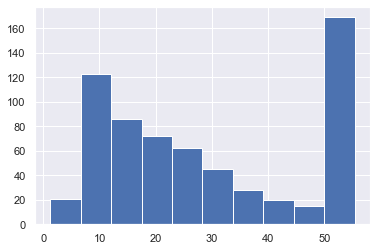

In [29]:
df_merged[ (df_merged['MASK'] == 255 ) ]['Radiance_32' ].hist()

<AxesSubplot:>

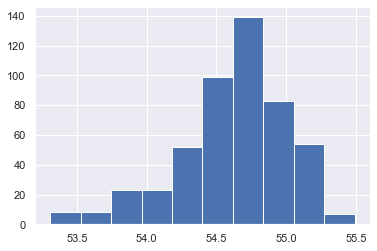

In [36]:
df_merged[ (df_merged['MASK'] == 253 ) ]['Radiance_32' ].hist()

<AxesSubplot:>

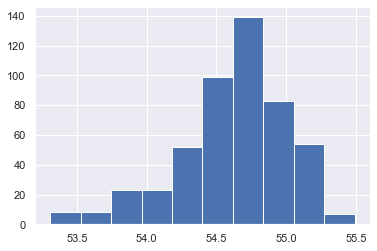

In [31]:
df_merged[ (df_merged['MASK'] == 253 ) ]['Radiance_32' ].hist()

<AxesSubplot:>

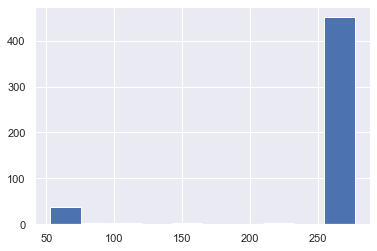

In [78]:
df_merged[ (df_merged['MASK'] == 253 ) ]['Radiance_26' ].hist()

<AxesSubplot:>

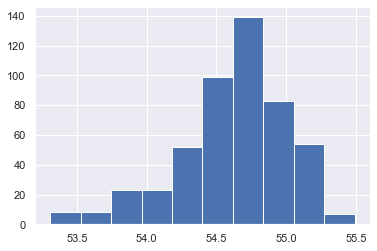

In [79]:
df_merged[ (df_merged['MASK'] == 253 ) ]['Radiance_32' ].hist()

In [53]:
df_wl.iloc[0,1]#['Central100%ResponseWavelengt']

0.462

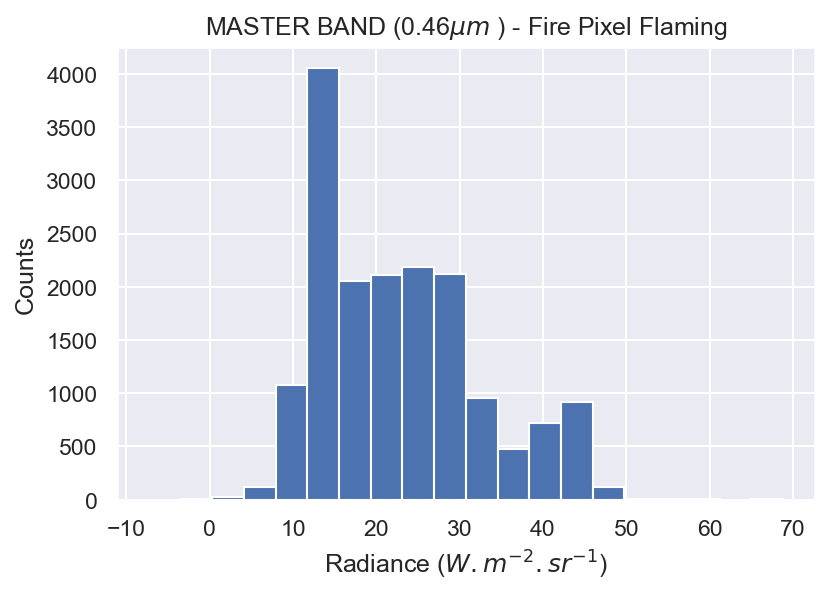

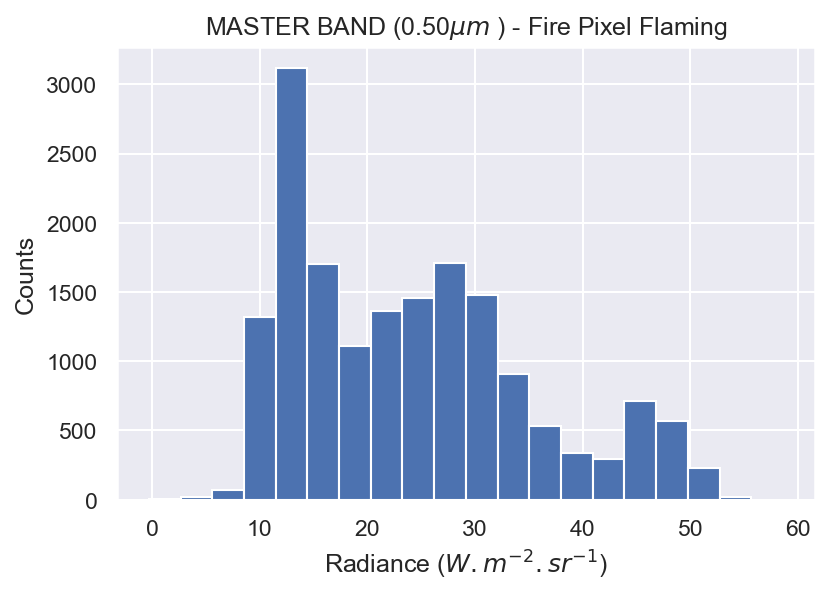

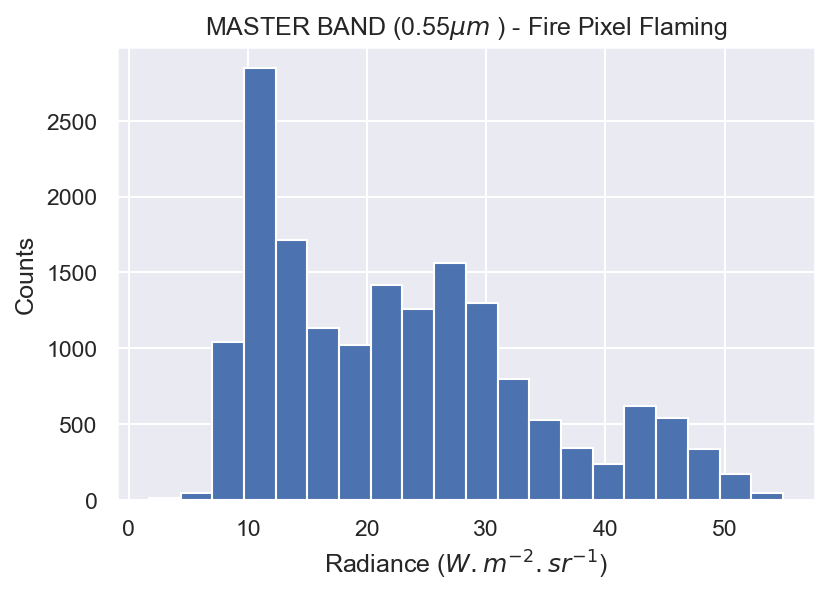

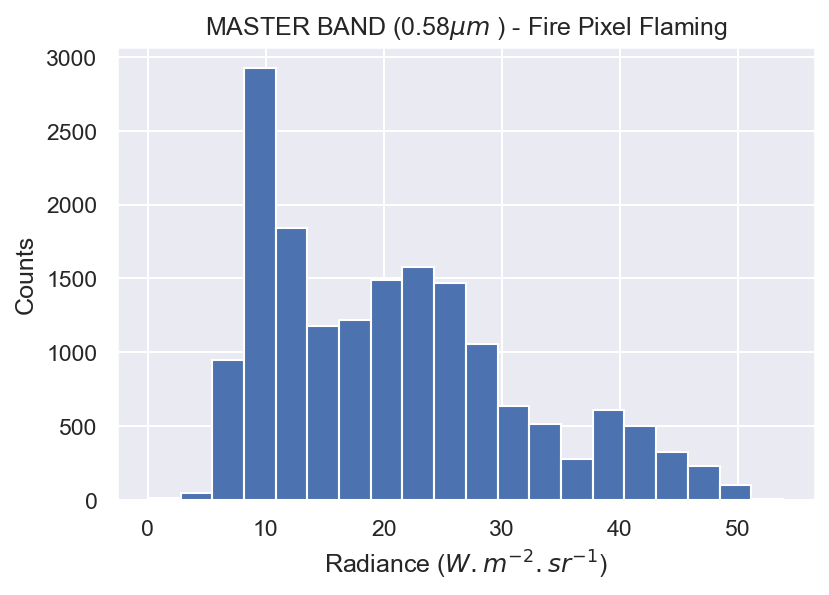

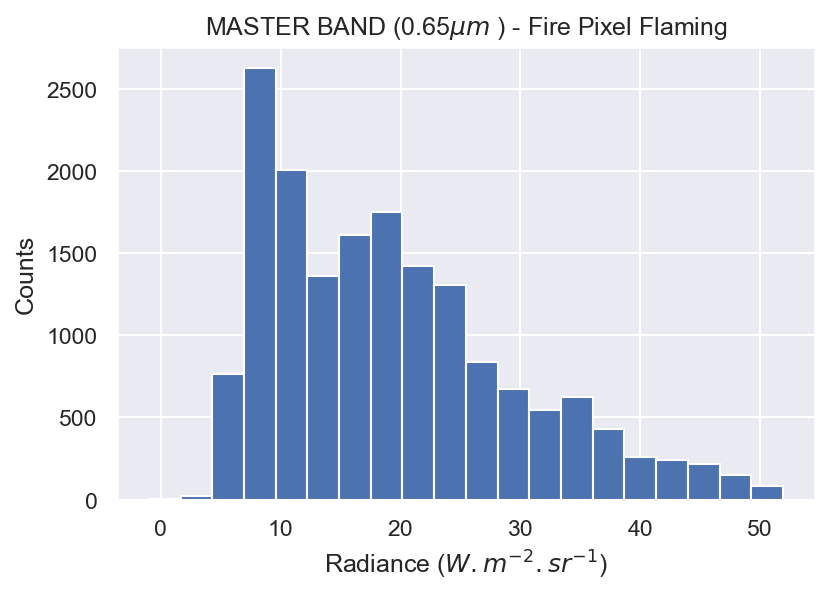

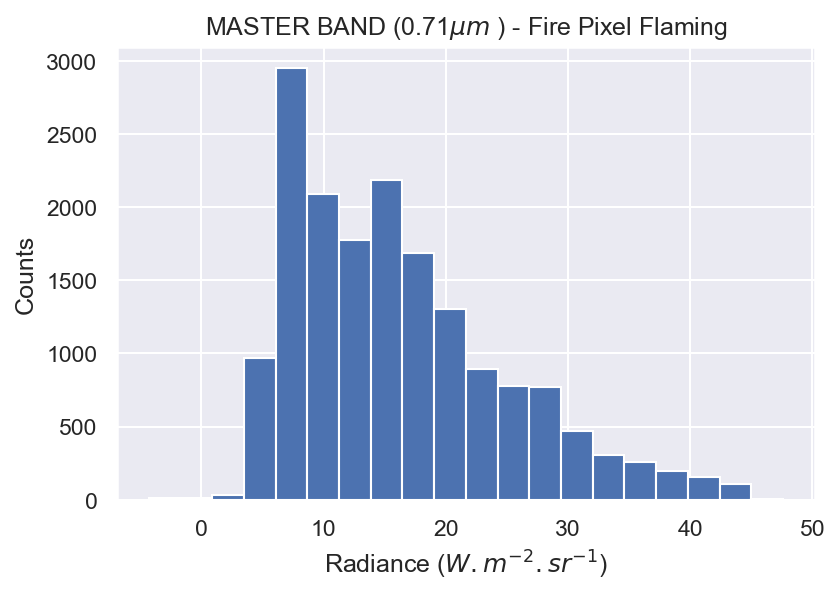

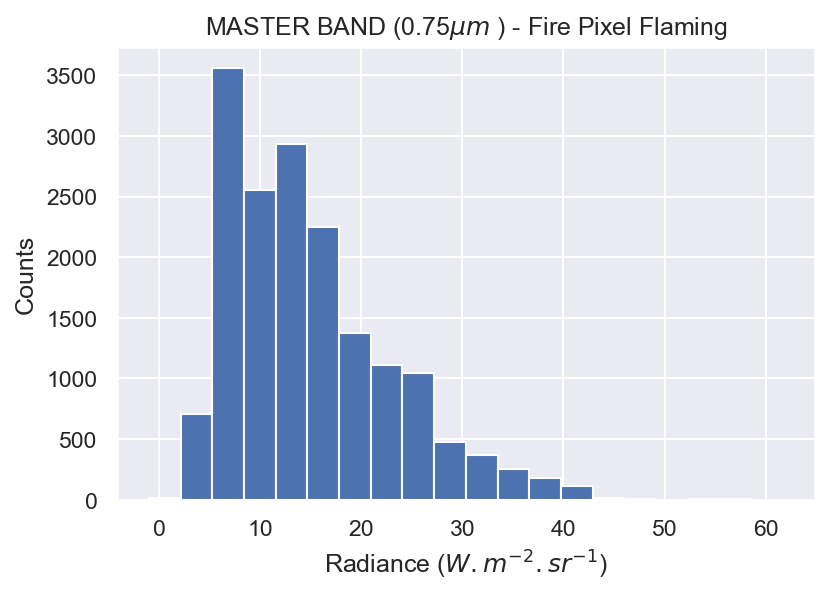

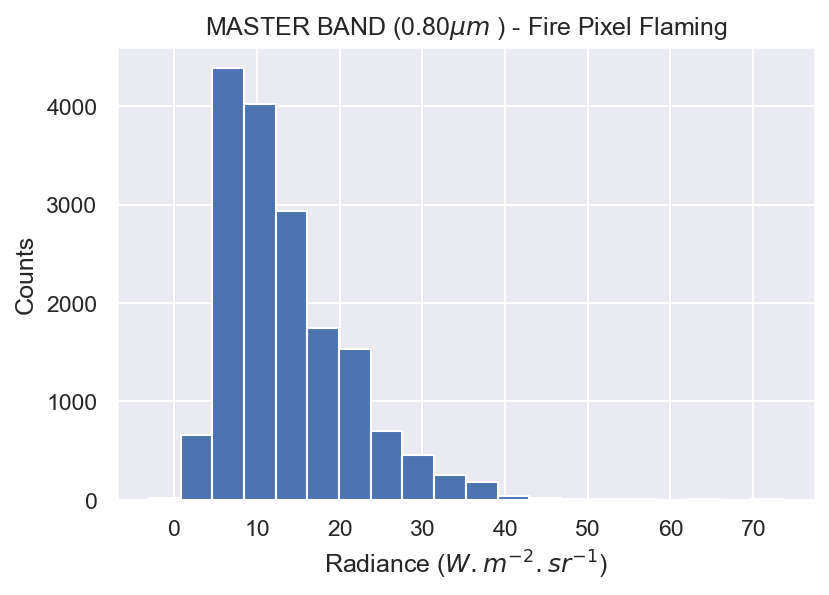

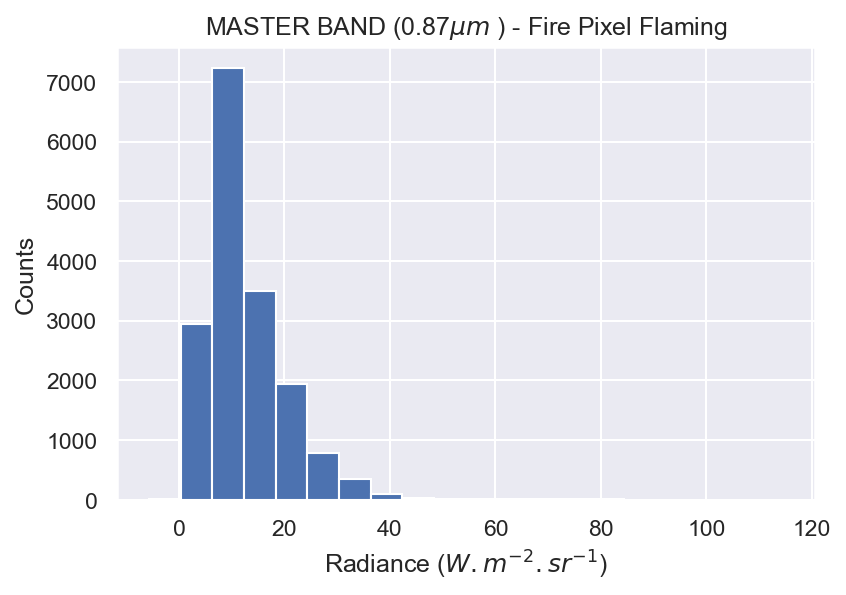

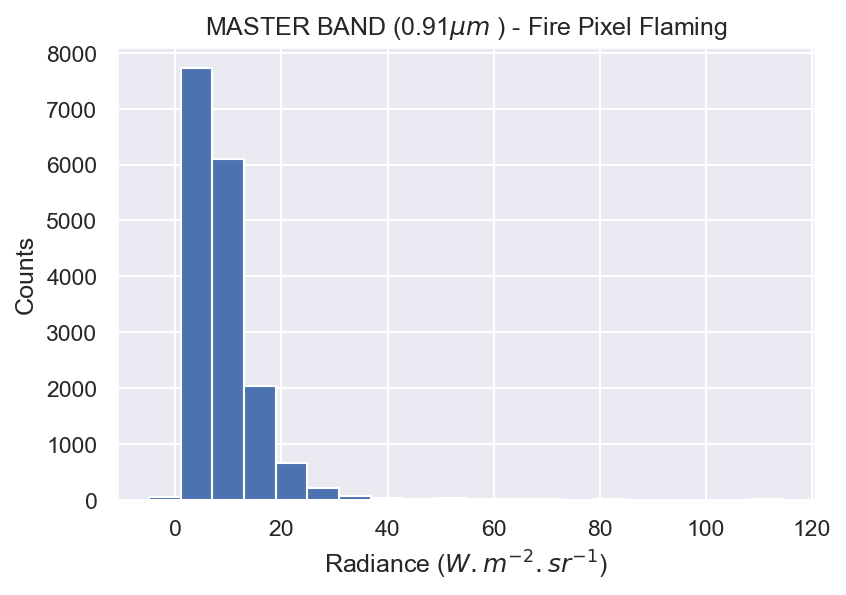

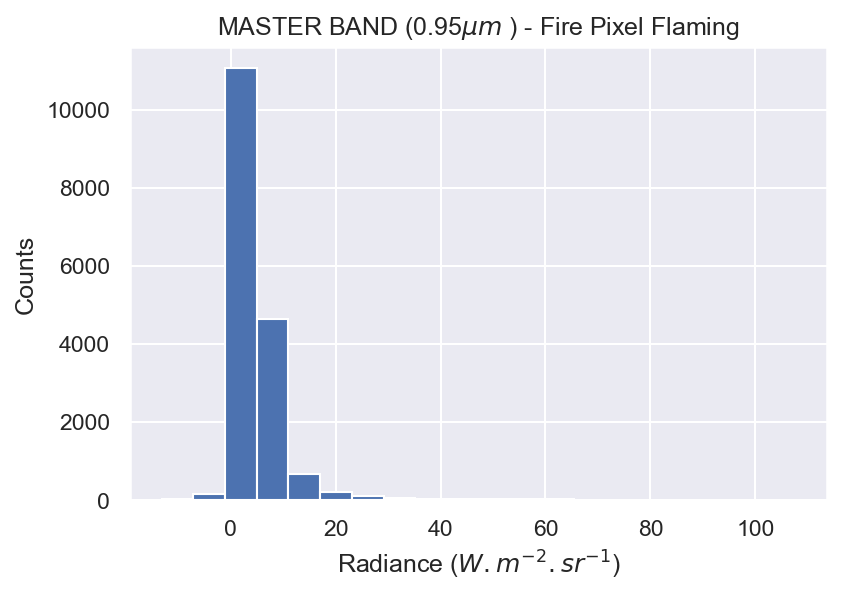

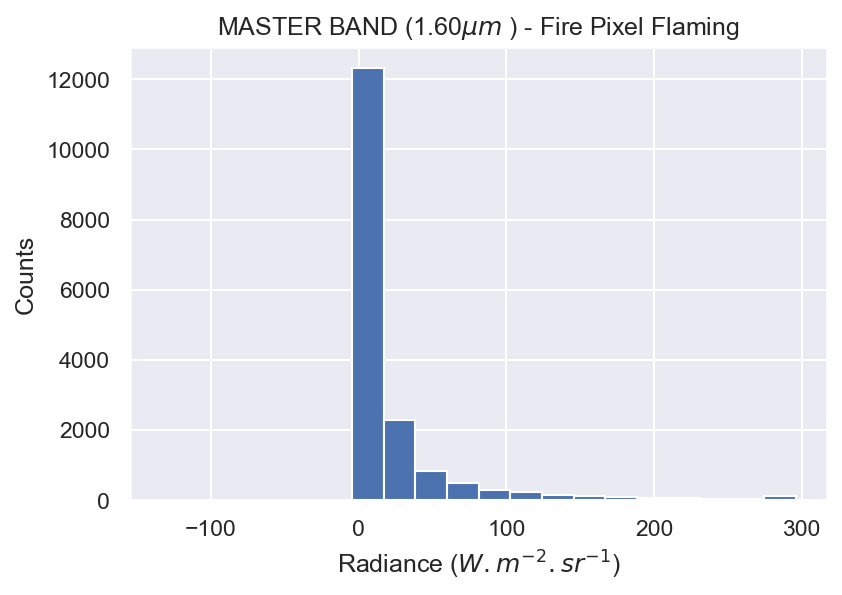

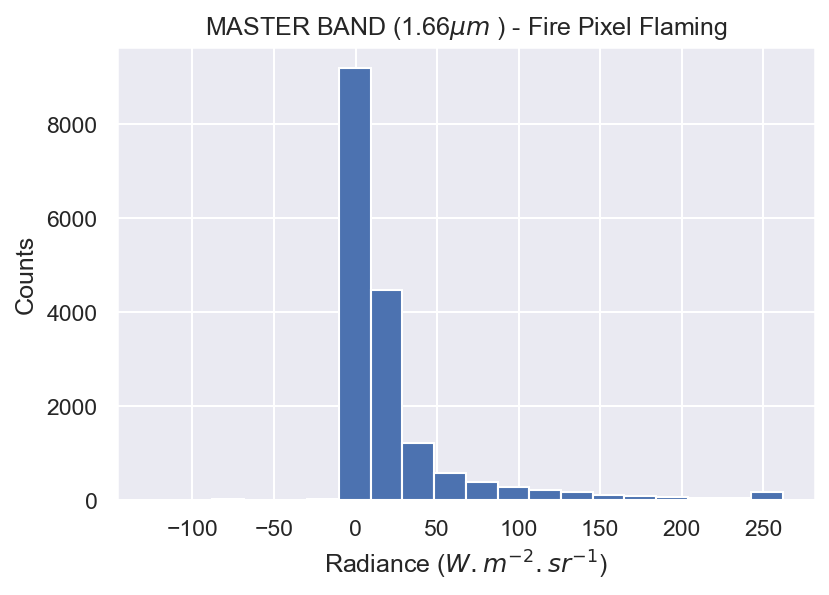

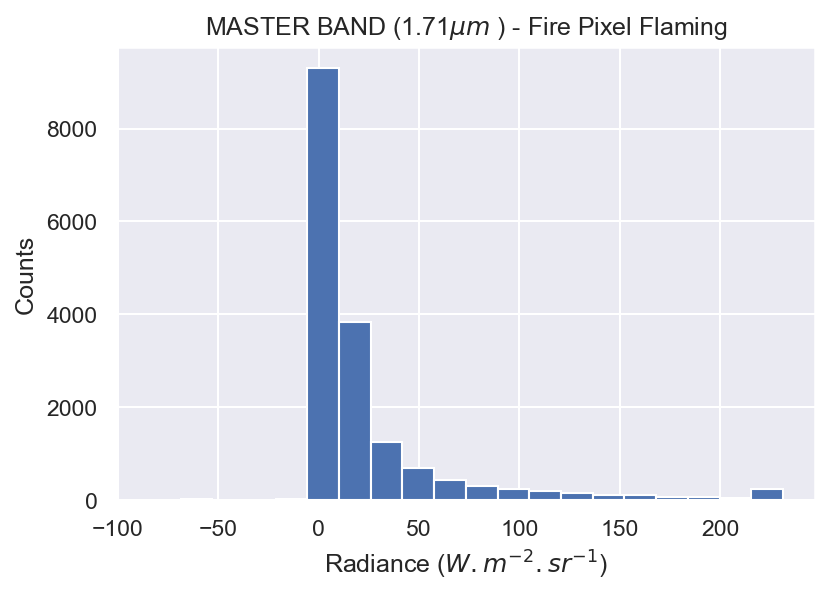

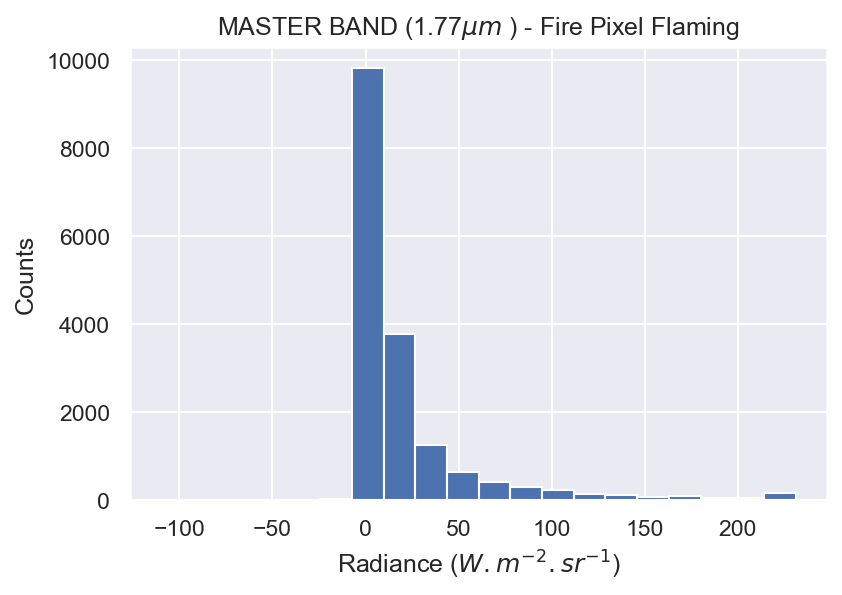

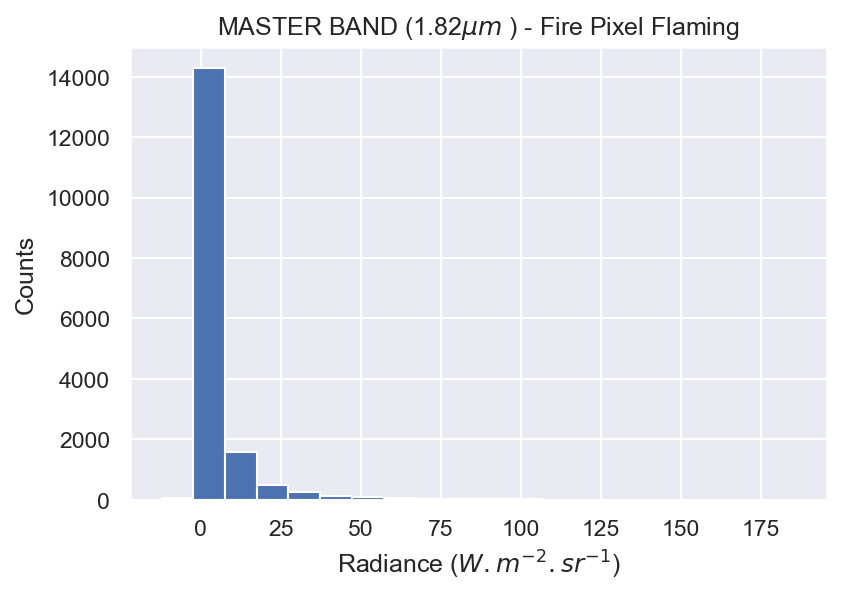

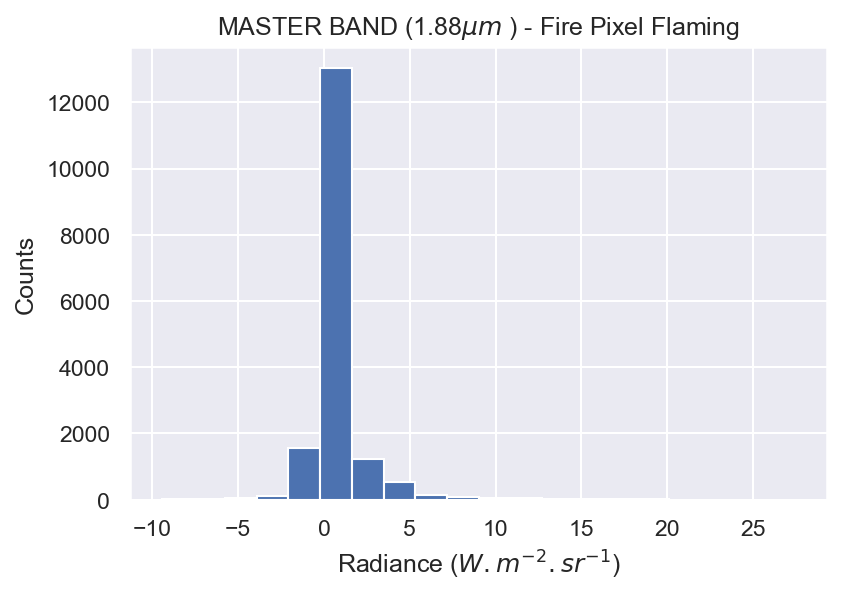

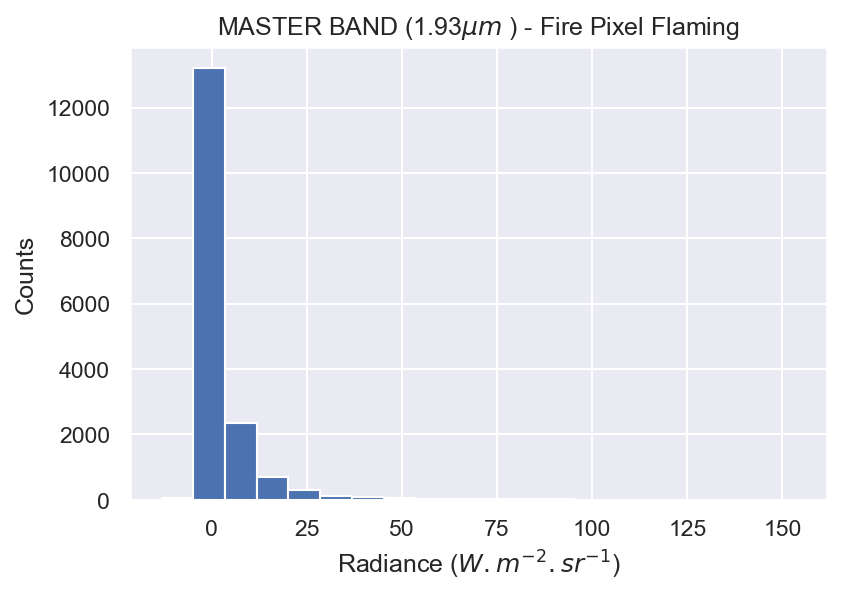

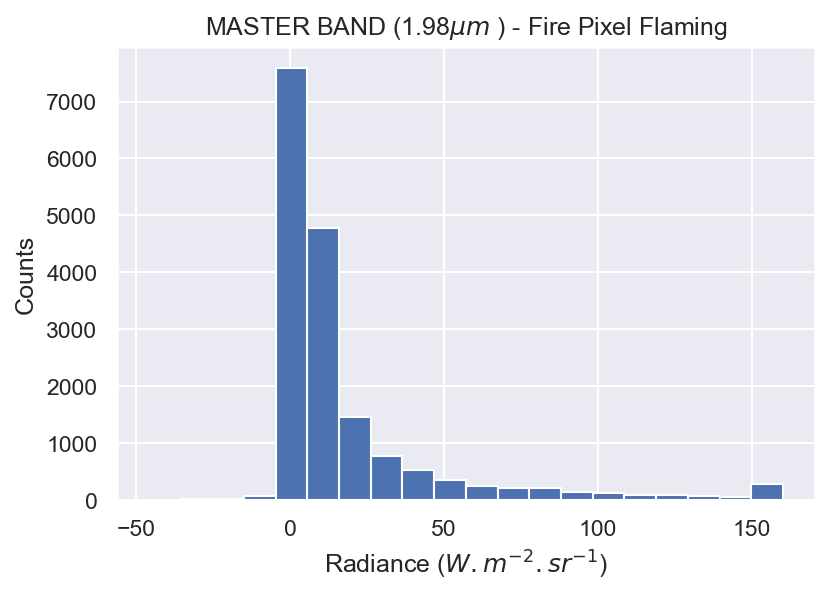

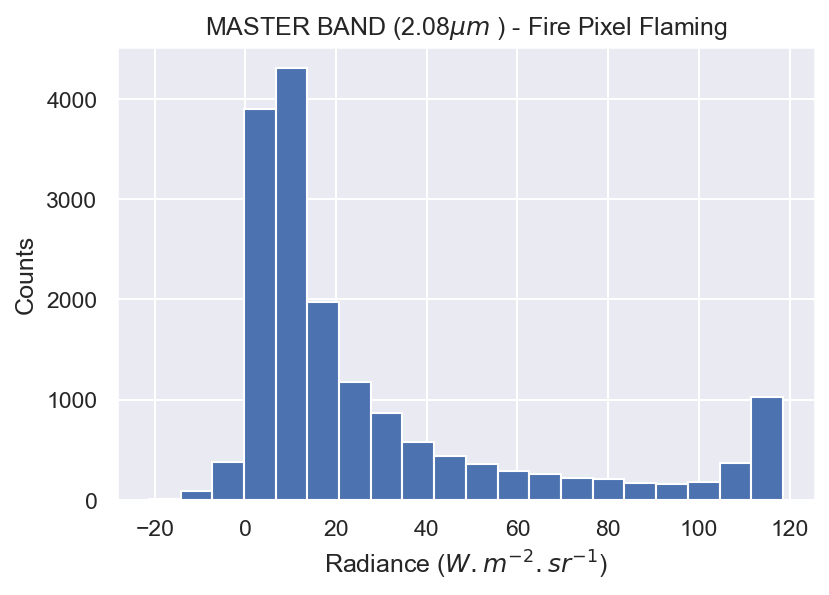

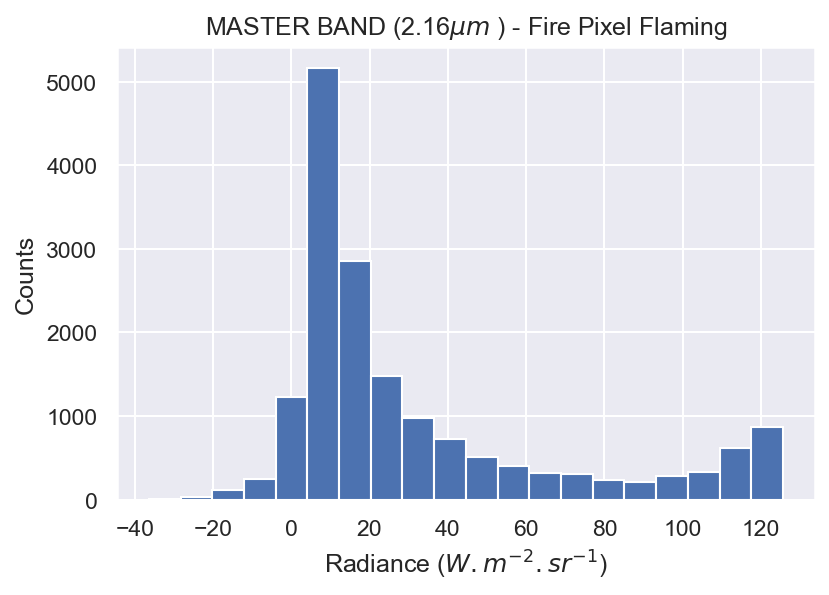

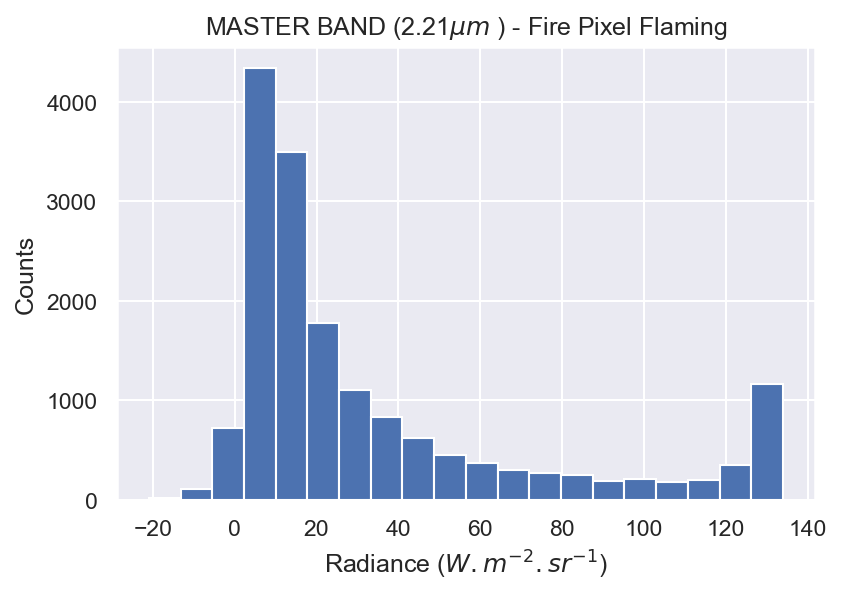

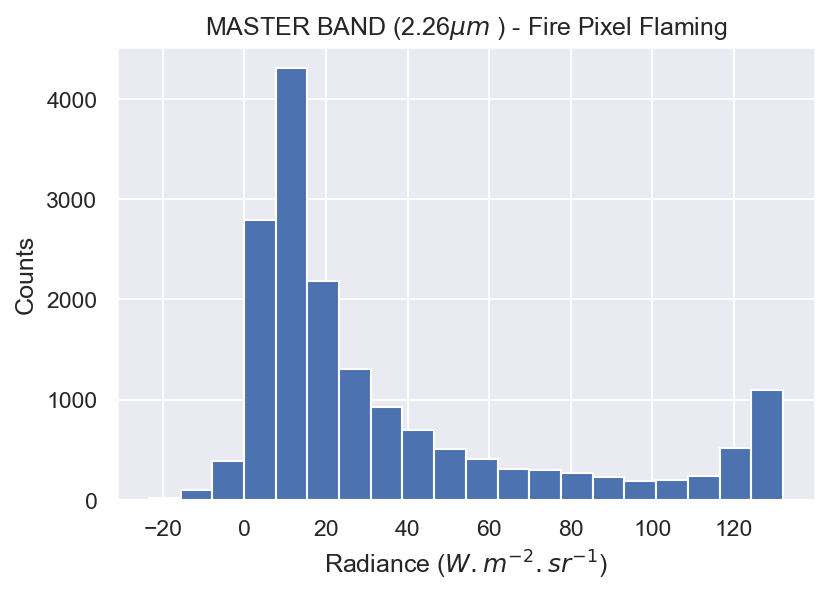

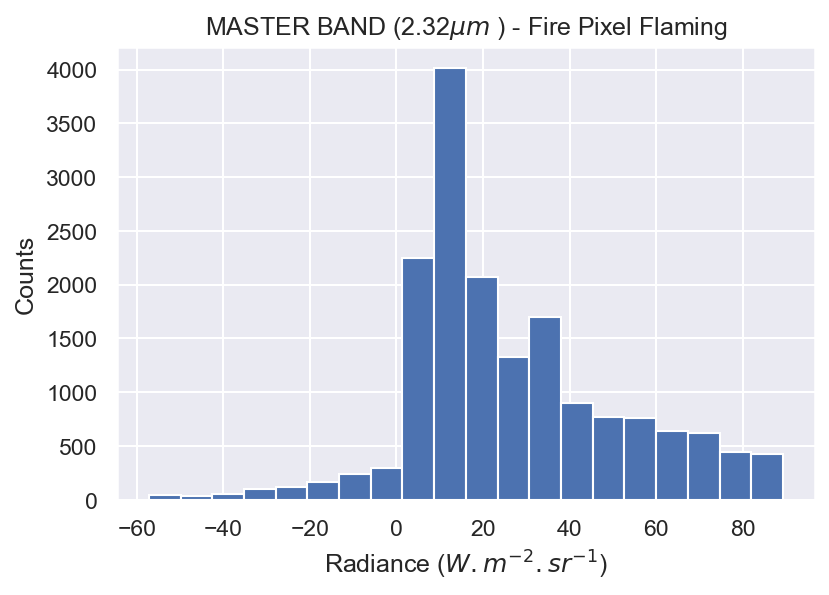

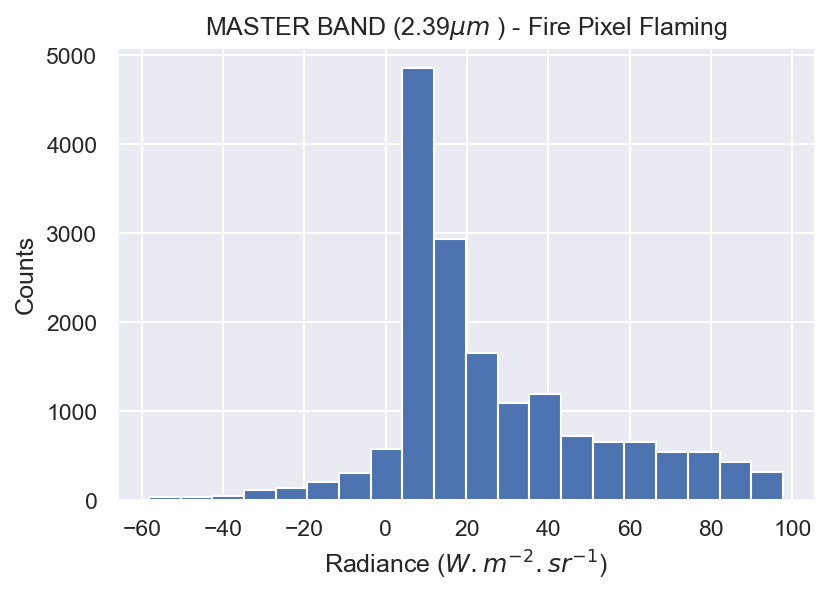

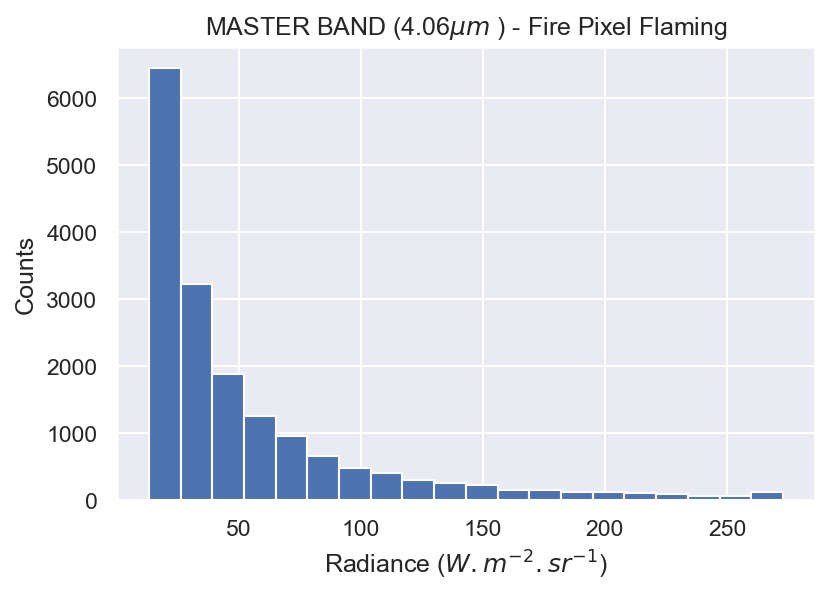

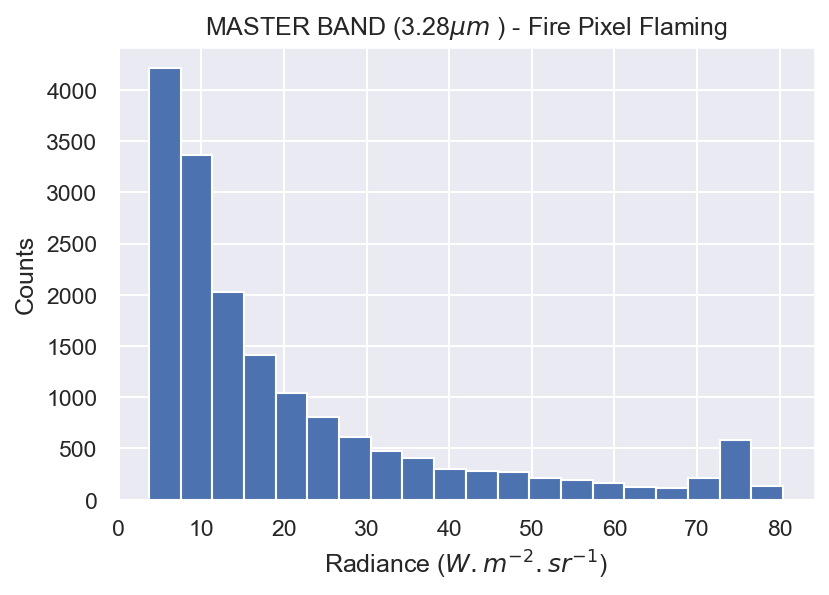

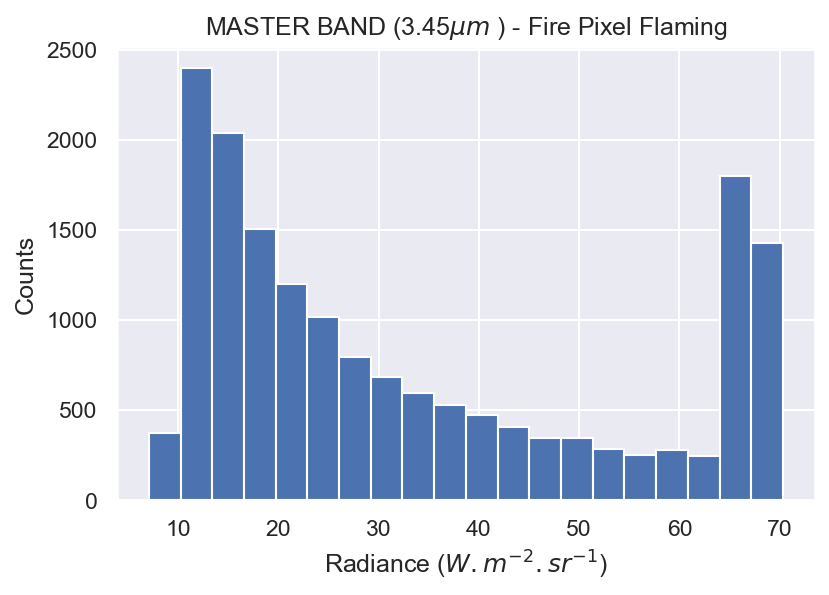

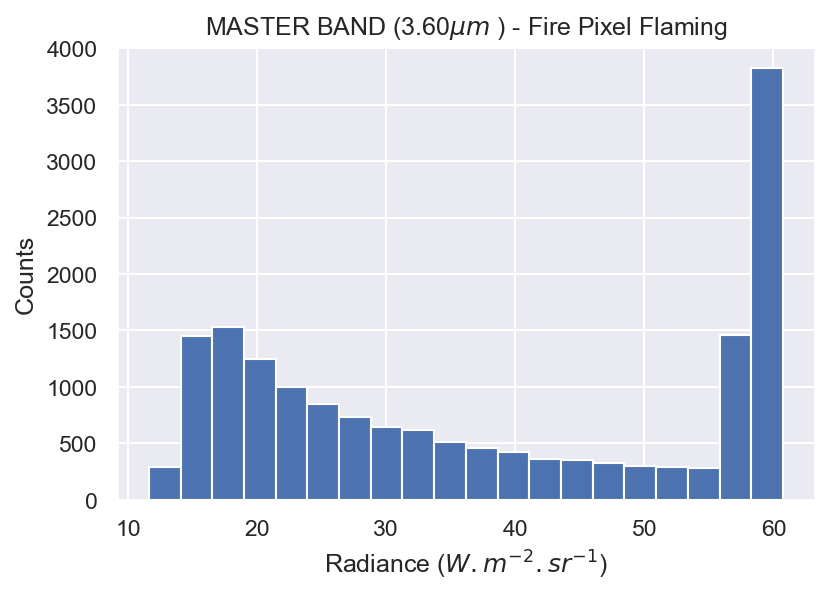

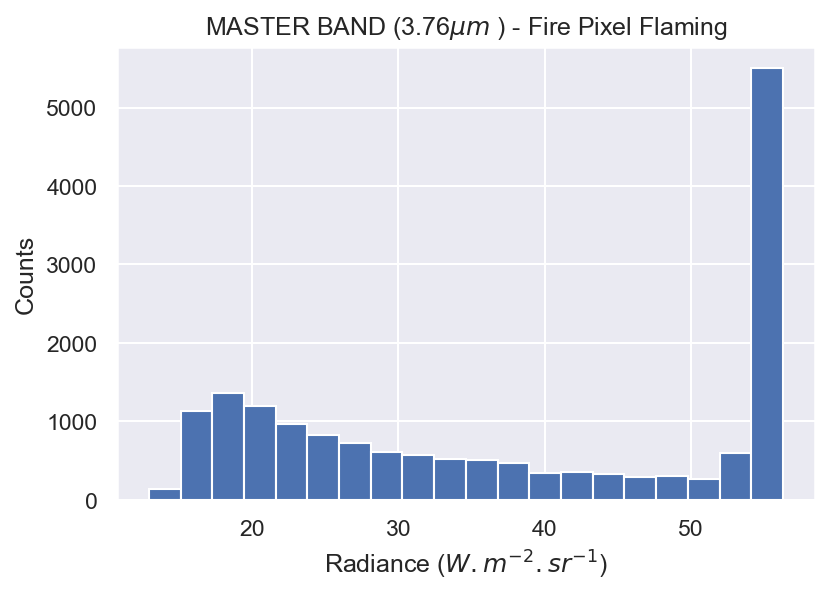

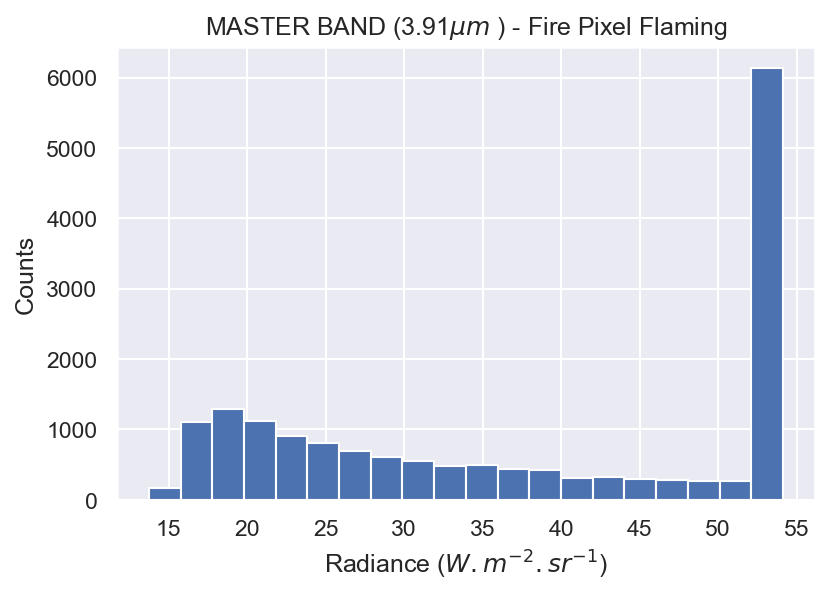

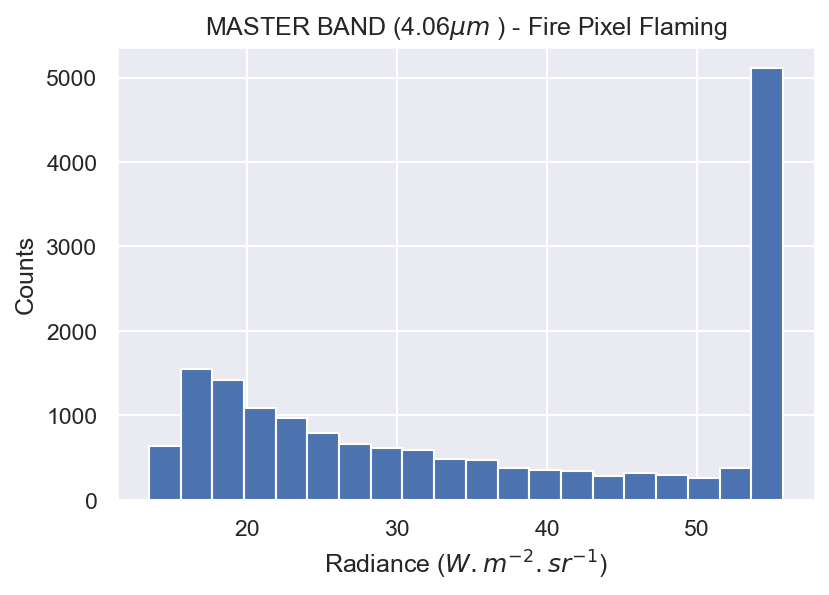

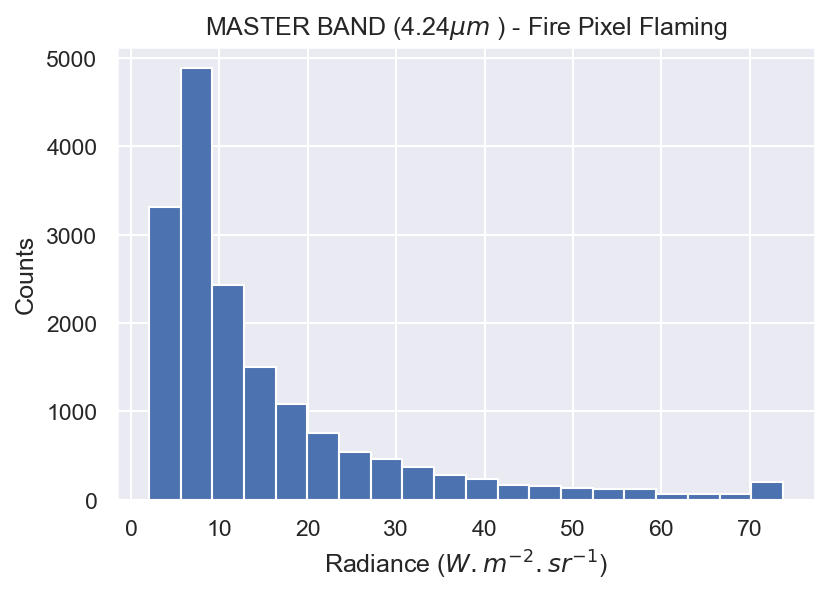

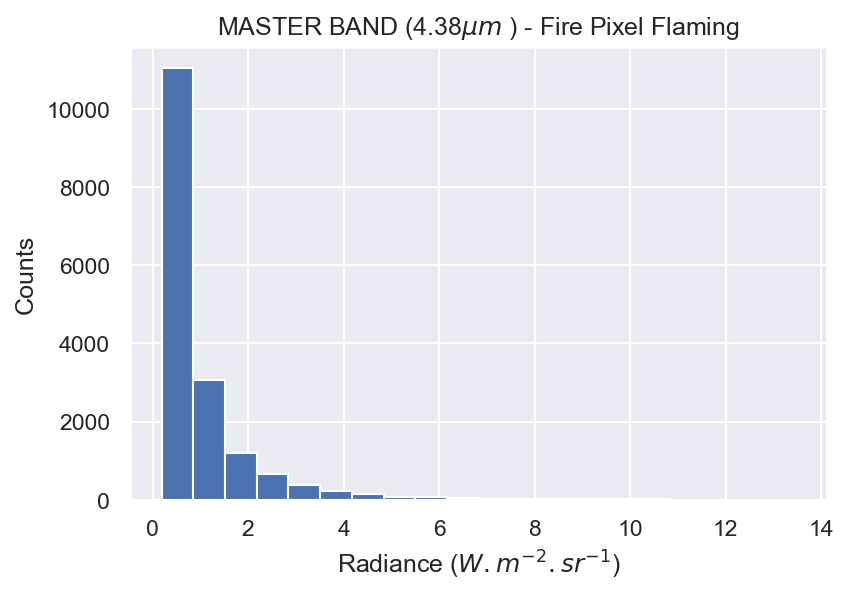

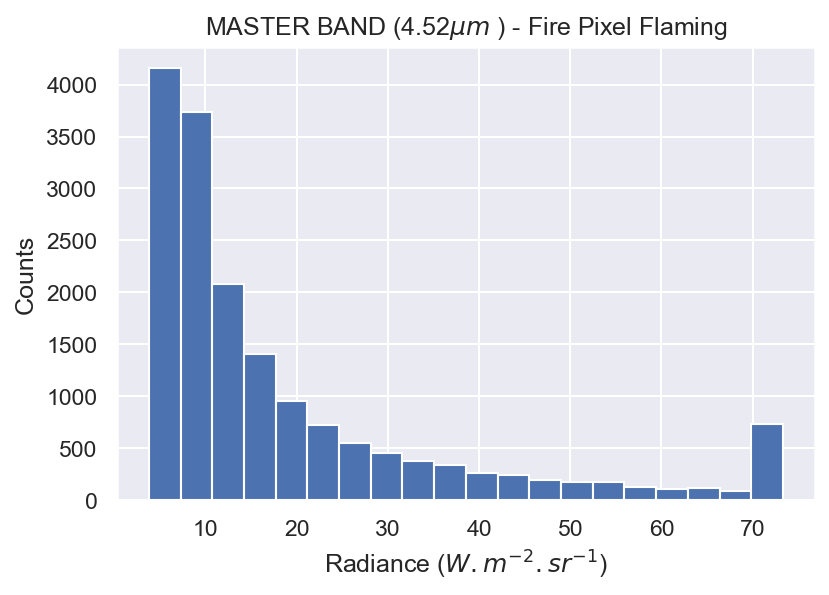

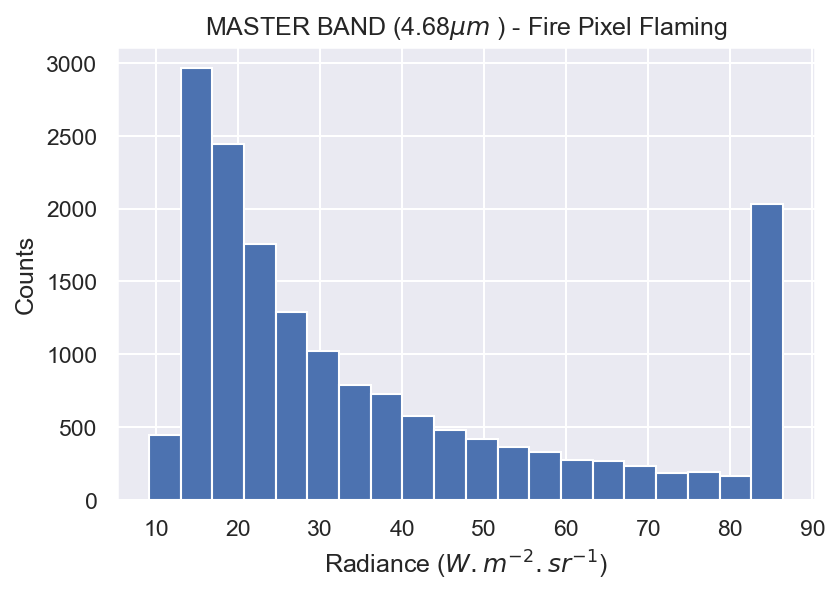

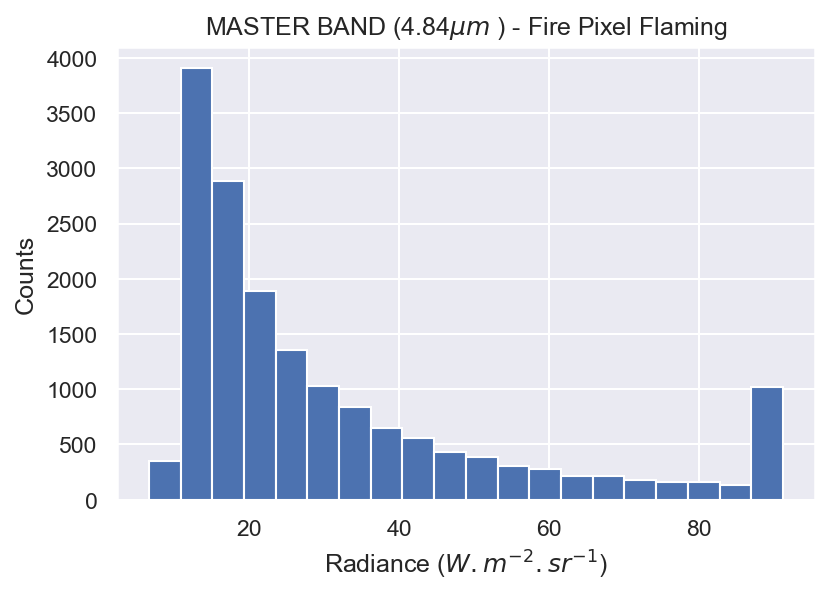

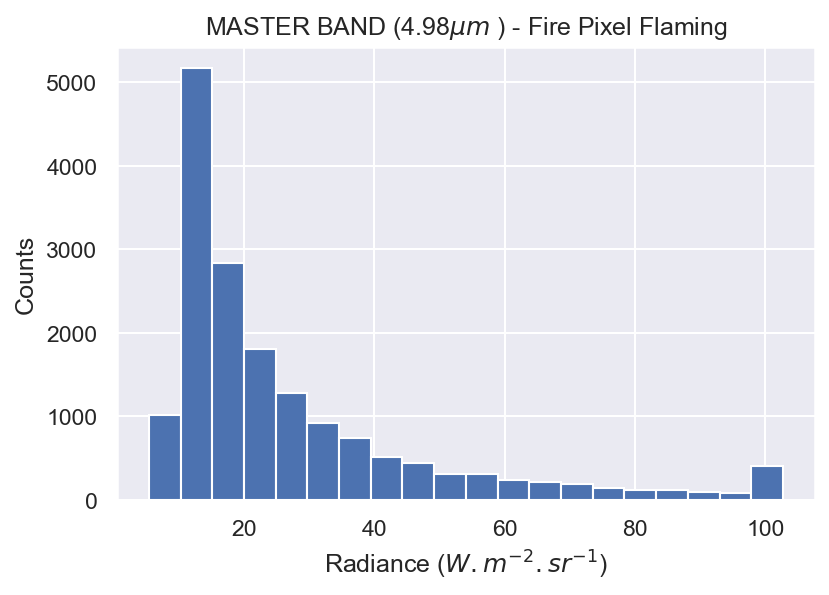

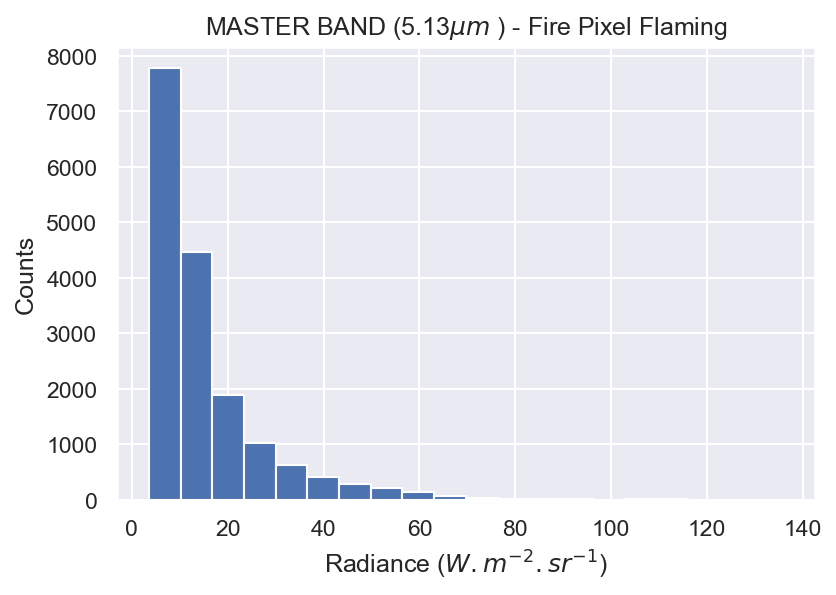

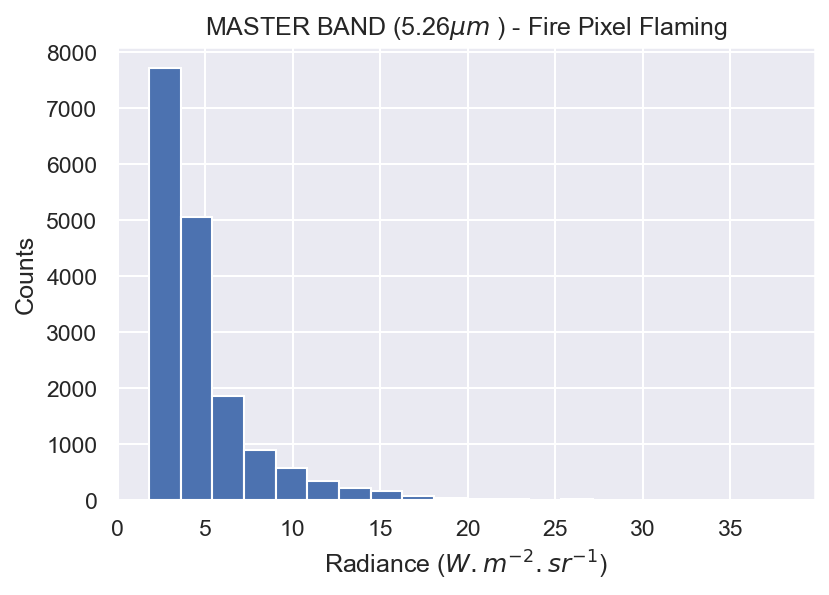

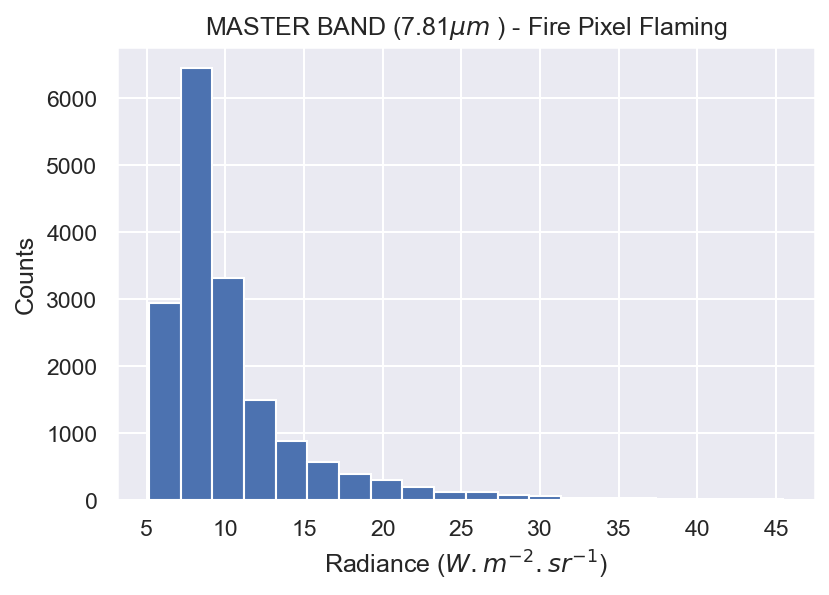

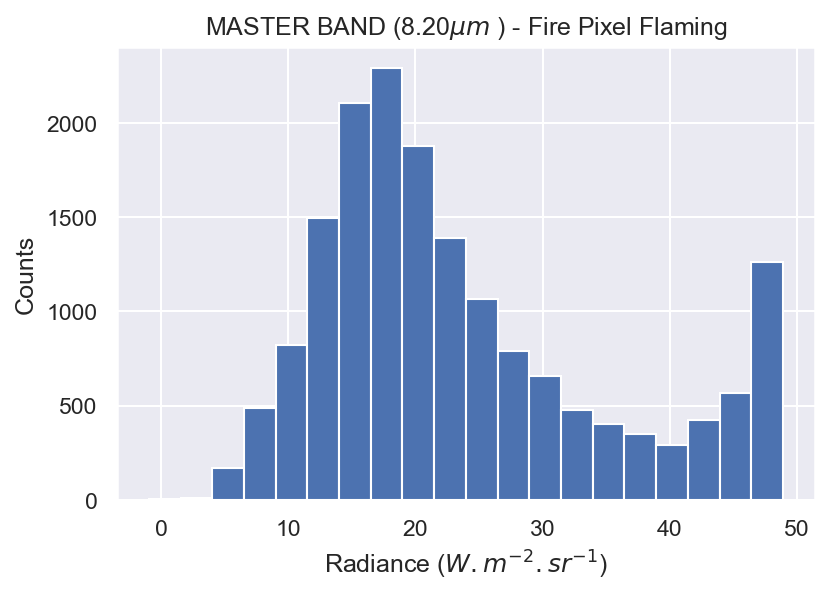

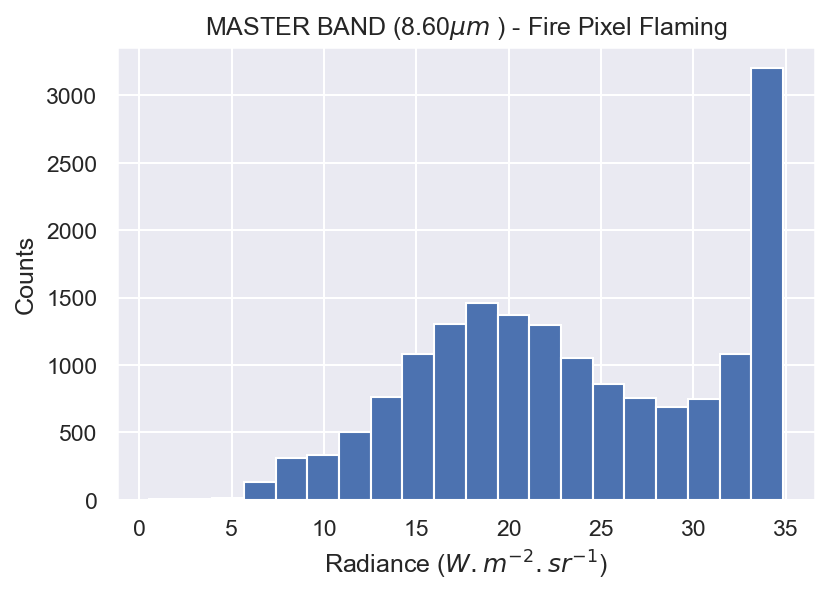

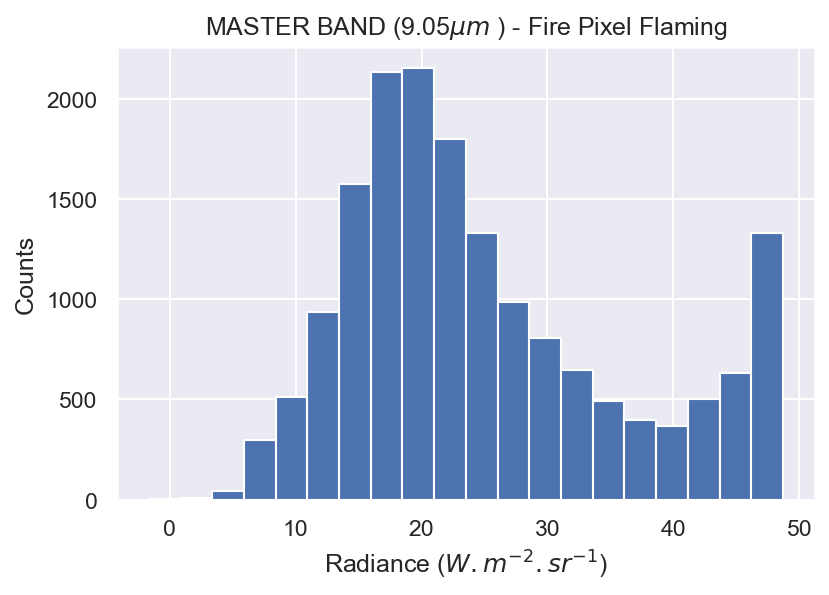

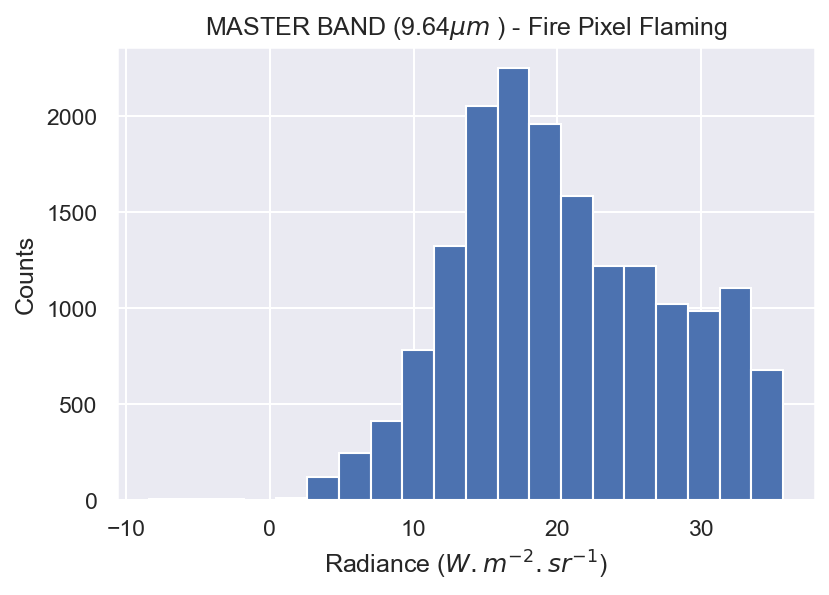

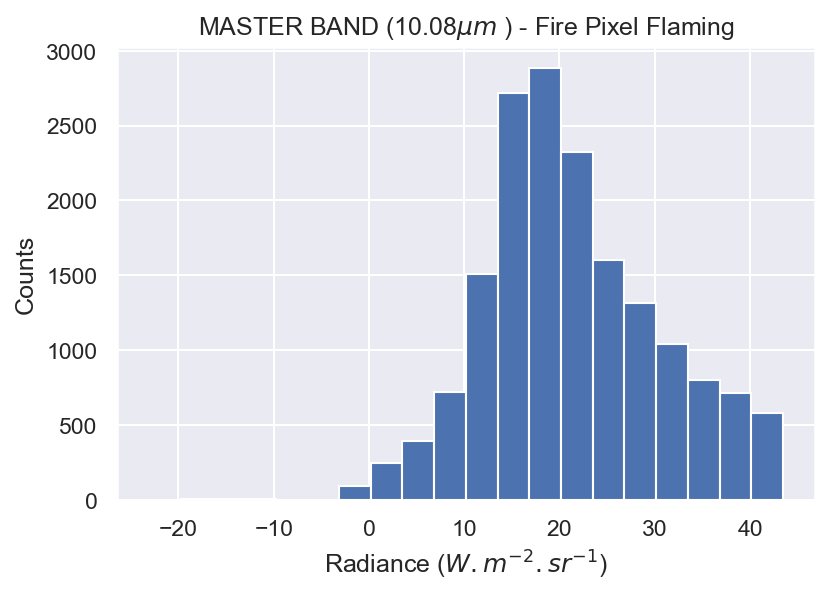

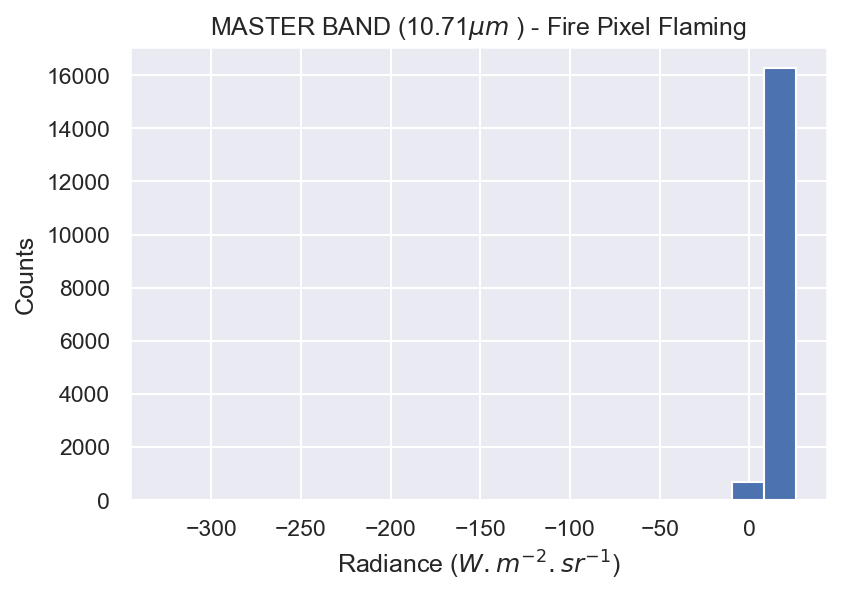

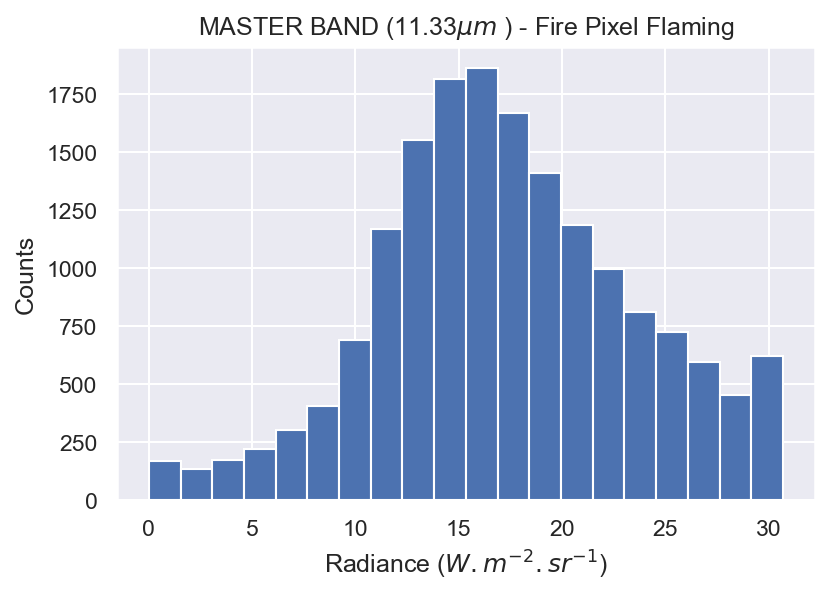

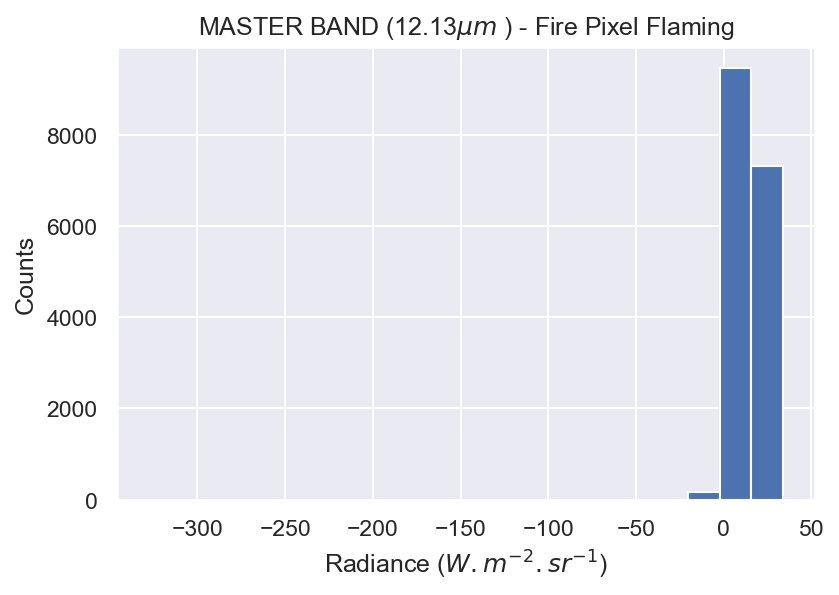

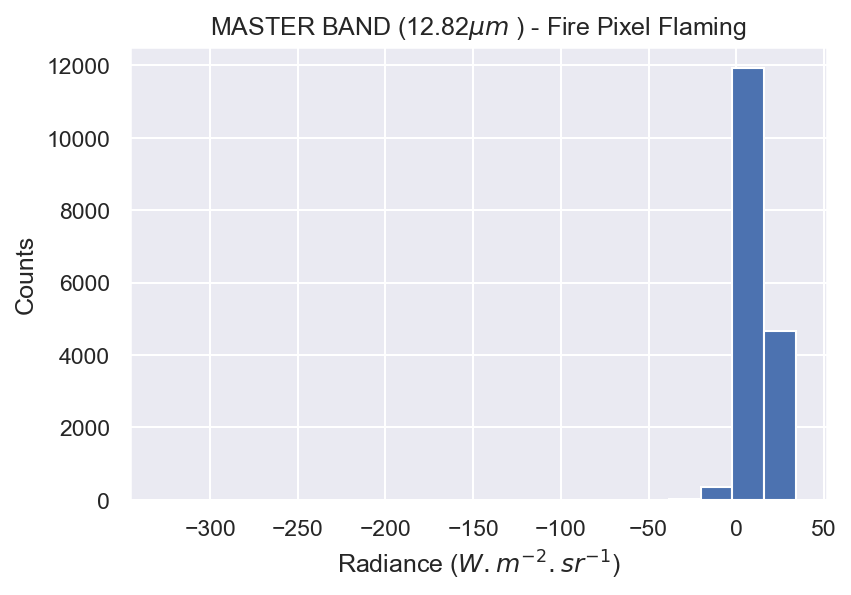

In [77]:
for band_idx in range(50):
    
    plt.figure(dpi=150, facecolor='w', edgecolor='k')
    
    df_merged[ (df_merged['MASK'] == 2 ) ]['Radiance_{:02d}'.format(band_idx+1) ].hist(bins=20)
    
    wl = round(df_wl.iloc[band_idx,1],2)
    
    plt.title(r'MASTER BAND ({:.2f}$\mu m$ ) - Fire Pixel Flaming'.format( wl  ))
    
    plt.xlabel(r'Radiance ($W.m^{-2}.sr^{-1}$)')
    plt.ylabel('Counts')
    
    filename = '{}_{}_Band_{}_Flaming'.format(Flight_Number, Flight_Track,band_idx+1)
    
    plt.savefig('./outputs/L1/1981715_15/{}.png'.format(filename, dpi=200, bbox_inches='tight'))
    
    plt.show()
    
    plt.close()

In [33]:
data = df_merged[ (df_merged['MASK'] == 255 ) ].filter(regex='Radiance',axis=1).to_numpy()

data

array([[32.10000048, 34.30000051, 32.60000049, ..., -0.57999999,
        -2.04999995, -5.69999987],
       [35.20000052, 35.40000053, 32.80000049, ..., -0.11      ,
        -2.04999995, -5.69999987],
       [21.70000032, 23.50000035, 23.00000034, ..., -1.04999998,
        -4.3999999 , -6.11999986],
       ...,
       [19.9000003 , 16.50000025, 14.20000021, ..., -0.38999999,
        -3.71999992, -5.26999988],
       [30.50000045, 27.0000004 , 23.80000035, ..., -0.28999999,
        -2.85999994, -4.6899999 ],
       [27.90000042, 25.80000038, 23.50000035, ..., -1.64999996,
        -5.05999989, -7.23999984]])

In [34]:
np.any(data<0,axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [39]:
file_name

'/Volumes/HD2/Datasets/Research/NASA/FIREXAQ/L1/MASTERL1B_1981715_15_20190730_0219_0231_V01.hdf'